# INF554 Kaggle challenge notebook
Team: Kagglers

Members: Marian Huot, Antoine Gleisberg, Aude Bouillé

## Part 0 : general imports and data reading

In [9]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from typing import List

import seaborn as sns

from sklearn.metrics import mean_absolute_error
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

from verstack.stratified_continuous_split import scsplit

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

from textblob import TextBlob
from textblob_fr import PatternTagger, PatternAnalyzer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\antoi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Load the training data
train_data = pd.read_csv("data/train.csv")

# Load the evaluation data
eval_data = pd.read_csv("data/evaluation.csv")

X = train_data.drop('retweets_count',axis=1)
y = train_data['retweets_count']

## Part 1 : data visualisation and feature plotting

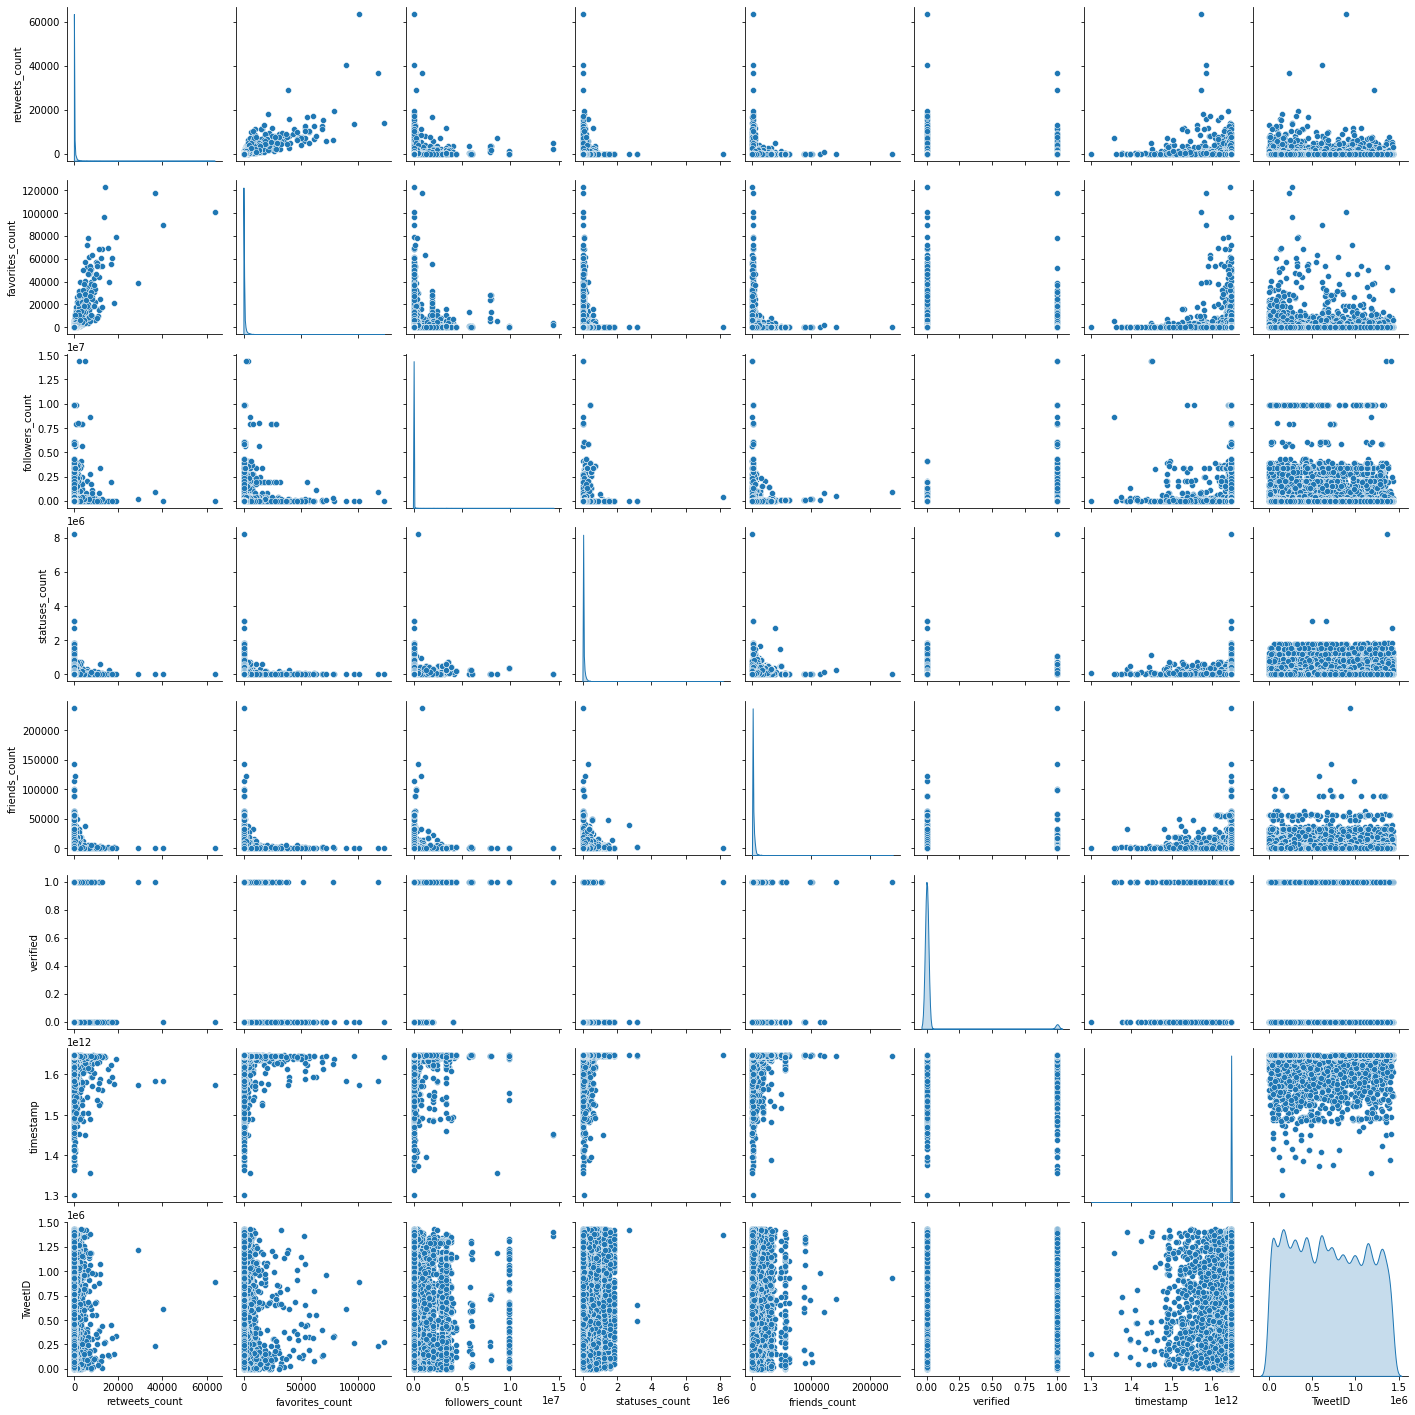

In [3]:
sns.pairplot(train_data, diag_kind='kde')

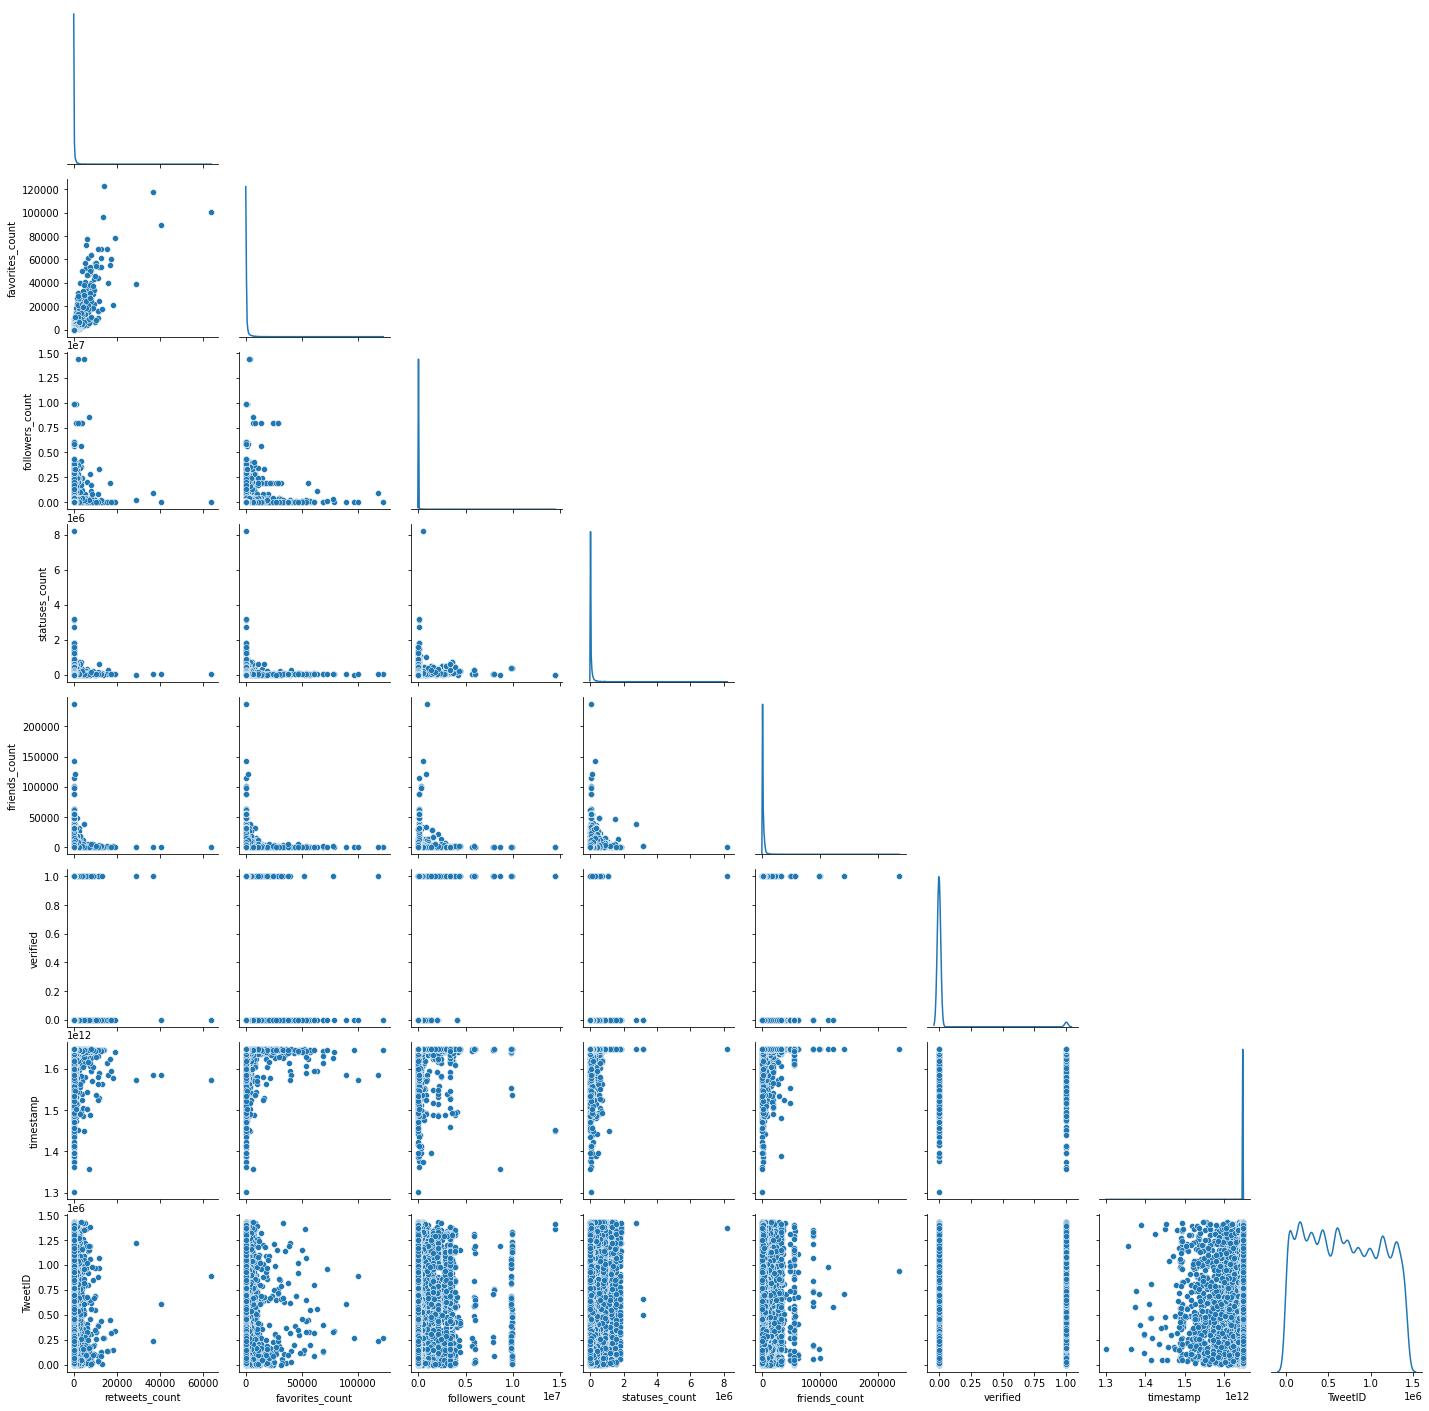

In [4]:
g = sns.PairGrid(train_data, diag_sharey=False, corner=True)
g.map_lower(sns.scatterplot)
g.map_diag(sns.kdeplot)

In [5]:
def visualize_retweets(n_max, n_min=-1, k=True, b=30):
    sns.displot(y[y < n_max][n_min < y], kde=k, bins=b)

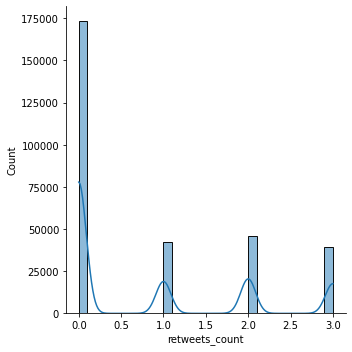

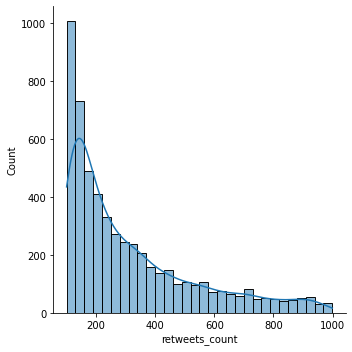

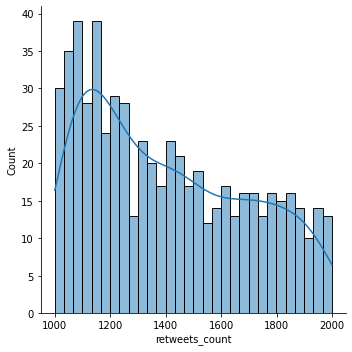

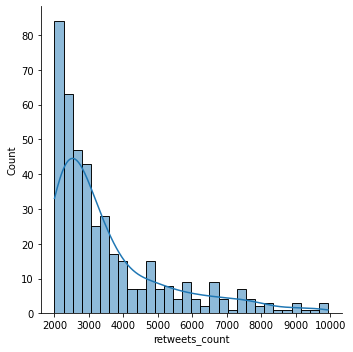

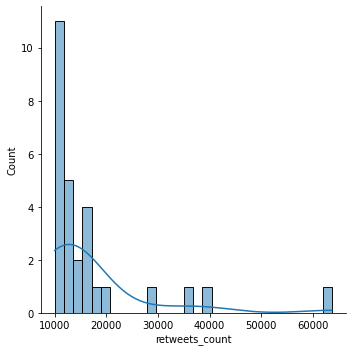

In [6]:
visualize_retweets(4)
visualize_retweets(1000, 100)
visualize_retweets(2000, 1000)
visualize_retweets(10000, 2000)
visualize_retweets(70000, 10000)

## Part 2 : Outlier removal and feature selection

### Part 2.1 : Removal of outliers

In [7]:
# remove outliers with quartile
def remove_outliers(df: pd.DataFrame, col: str) -> pd.DataFrame:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    df = df[(df[col] >= q1 - 5 * iqr) & (df[col] <= q3 + 5 * iqr)]
    return df

# remove outliers with given percentage p
def remove_outliers_percentage(df, col, p):
    q = df[col].quantile(1 - p / 100)
    df = df[df[col] < q]
    return df

# remove outliers with retweets_count above n
def remove_outliers_above(df, col, n):
    df = df[df[col] < n]
    return df

def percentage_outliers_above(df, col, n):
    z = df[col].copy()
    z[z < n] = 0
    print("n:")
    print(n)
    print("Percentage of outliers:")
    print(len(z[z>n])/len(z) * 100)

In [8]:
percentage_outliers_above(train_data, 'retweets_count', 7000)

n:
7000
Percentage of outliers:
0.01553808384350042


### Part 2.2 : Train - Test split

In [17]:
# split data using stratified continuous split
X_train, X_test, y_train, y_test = scsplit(train_data, train_data['retweets_count'], stratify=train_data['retweets_count'], train_size=0.8, test_size=0.2)

# We remove the actual number of retweets from our features since it is the value that we are trying to predict
X_train = X_train.drop(['retweets_count'], axis=1)
X_test = X_test.drop(['retweets_count'], axis=1)


# split data using sklearn
# X = train_data.drop('retweets_count',axis=1)
# y = train_data['retweets_count']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Part 2.3 : Adding new features

In [18]:
def feature_engineering(input_df: pd.DataFrame) -> pd.DataFrame:
    res_df = input_df

    # add a column to data which counts url
    res_df['url_count'] = res_df['urls'].str.count('http')
    # add columns to data which makes ratios
    res_df['followers_friends'] = res_df['followers_count'] / (res_df['friends_count'].apply(lambda x: x+1))
    
    return res_df


def time_engineering(input_df: pd.DataFrame) -> pd.DataFrame:
    res_df = input_df
    res_df["hour"] = res_df['timestamp'].apply(
        lambda t: (datetime.fromtimestamp(t//1000).hour))
    res_df["day"] = res_df['timestamp'].apply(
        lambda t: (datetime.fromtimestamp(t//1000)).weekday())
    res_df["week_in_month"] = res_df['timestamp'].apply(
        lambda t: (datetime.fromtimestamp(t//1000).day)//7)

    return res_df
    
def extract_topic(input_df: pd.DataFrame) -> pd.DataFrame:
    res_df = input_df
    res_df['hashtags'] = res_df['hashtags'].apply(
        lambda x: x.replace('[', '').replace(']', '').replace("'", ''))
    #join text and hashtags
    res_df['total_text'] = res_df['text'] + ' ' + res_df['hashtags']
    vectorizer = TfidfVectorizer(min_df=1, max_features=None, stop_words=stopwords.words('french'))
    vector = vectorizer.fit_transform(res_df['total_text'])
    svd = TruncatedSVD(n_components=5, n_iter=7, random_state=42)
    svd.fit(vector)
    topic=svd.transform(vector)
    res_df['topic_1'] = topic[:,0]
    res_df['topic_2'] = topic[:,1]
    res_df['topic_3'] = topic[:,2]
    res_df['topic_4'] = topic[:,3]
    res_df['topic_5'] = topic[:,4]
    return res_df

def text_engineering(input_df: pd.DataFrame) -> pd.DataFrame:
    res_df = input_df
    # add columns related to sentiment analysis
    res_df['polarity'] = res_df['total_text'].apply(lambda x: TextBlob(
        x, pos_tagger=PatternTagger(), analyzer=PatternAnalyzer()).sentiment[0])
    res_df['subjectivity'] = res_df['total_text'].apply(lambda x: TextBlob(
        x, pos_tagger=PatternTagger(), analyzer=PatternAnalyzer()).sentiment[1])

    return res_df

def hashtags_engineering(input_df):
    res_df = input_df
    
    # add a column to data which gives number of hashtags
    res_df['hashtags_count'] = res_df['hashtags'].apply(lambda hashtags: len(hashtags.split(",")) if hashtags != "" else 0)
    
    return res_df

def extract_cluster(input_df: pd.DataFrame, columns: List[str]) -> pd.DataFrame:
    res_df = input_df
    res_df['cluster'] = KMeans(n_clusters=100, random_state=0).fit_predict(res_df[columns].values)
    return res_df

### Part 2.4 : Feature selection

In [19]:
columns = ['TweetID', 'mention', 'urls', 'timestamp', 'text', 'total_text', 'hashtags', 'followers_count', 'friends_count', 'favorites_count', 'statuses_count', 'verified', 'url_count', 'followers_friends',
       'hour', 'day','week_in_month', 'polarity', 'subjectivity', 'hashtags_count', 'topic_1','topic_2', 'topic_3','topic_4', 'topic_5','cluster']

useless_cols = ["mention", "urls", "timestamp", "TweetID", "text", "hashtags", "total_text"]

In [20]:
def clean_data(input_df: pd.DataFrame) -> pd.DataFrame:
    res_df = input_df
    res_df = feature_engineering(res_df)
    res_df = time_engineering(res_df)
    res_df = extract_topic(res_df)
    res_df = text_engineering(res_df)
    res_df = hashtags_engineering(res_df)
    res_df = extract_cluster(res_df, ['followers_count', 'friends_count', 'favorites_count', 'statuses_count', 'followers_friends', 'polarity', 'subjectivity', 'hashtags_count'])
    res_df = res_df.reindex(columns=columns)
    res_df = res_df.drop(useless_cols, axis=1)
    return res_df

In [21]:
new_train_data = clean_data(X_train)
new_test_data = clean_data(X_test)

This section was used for testing purposes : trying to remove different features for the best possible results

In [22]:
unimportant_cols = remove=['verified', 'url_count', 'week_in_month','day', 'topic_2', 'topic_3', 'topic_4', 'topic_5']

In [23]:
new_train_data = new_train_data.drop(unimportant_cols, axis=1)
new_test_data = new_test_data.drop(unimportant_cols, axis=1)

In [24]:
new_train_data.head()

,followers_count,friends_count,favorites_count,statuses_count,followers_friends,hour,polarity,subjectivity,hashtags_count,topic_1,cluster
263303,85,109,0,3194,0.772727,8,0.6,0.70,0,0.035776,76
42992,8255,4647,0,8957,1.776033,13,-0.7,0.70,0,0.015108,96
85327,277,88,0,33577,3.112360,7,0.0,0.00,0,0.002549,68
62790,72,740,0,4971,0.097166,11,-0.7,0.90,0,0.211956,0
277391,1846,2930,39,21496,0.629819,15,-0.2,0.25,0,0.070476,32


### Maybe add autoML section here

## Part 3 : Model selection

Importing different regressors

In [25]:
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso


from sklearn.dummy import DummyRegressor

In [ ]:
mse_model = RandomForestRegressor(max_features=0.8773890634249363, max_leaf_nodes=2133, n_estimators=23, n_jobs=-1)

xgb_model = XGBRegressor(base_score=0.5, booster='gbtree', callbacks=[],
             colsample_bylevel=0.9876392518281302, colsample_bynode=1,
             colsample_bytree=1.0, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, gpu_id=-1, grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.10345093113695748,
             max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=8, max_leaves=0,
             min_child_weight=1.051080893063133, 
             monotone_constraints='()', n_estimators=25, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=0, 
             reg_alpha= 0.0400147579159508, reg_lambda= 1.4102515706547767, 
             sampling_method= 'uniform', scale_pos_weight= 1, subsample= 0.7946527720376892, 
             tree_method= 'exact', validate_parameters= 1, verbosity= 0, use_label_encoder= False)

models = [xgb_model, mse_model]

In [ ]:
def write_predictions_to_file(file_name, eval_data, predictions):
    with open(file_name, 'w') as f:
        writer = csv.writer(f)
        writer.writerow(["TweetID", "retweets_count"])
        for index, prediction in enumerate(predictions):
            writer.writerow([str(eval_data['TweetID'].iloc[index]) , str(int(prediction))])

In [31]:
for model in models:
    model.fit(new_train_data, y_train)
    predictions = model.predict(new_test_data)
    predictions = [round(value) if value >= 0 else 0 for value in predictions]
    write_predictions_to_file(f"{model.__class__.__name__}.csv", X_test, predictions)
    print(f"{model.__class__.__name__} done.\nMean absolute error: {mean_absolute_error(y_test, predictions)}")

XGBRegressor done.
Mean absolute error: 6.69104726389242
RandomForestRegressor done.
Mean absolute error: 6.98059157555725


## Part 4 : Visualising importance of model features

In [ ]:
from scipy.cluster import hierarchy
%matplotlib inline
feature_importance = pd.DataFrame({'feature': new_train_data.drop(
    remove, axis=1).columns, 'importance': model.feature_importances_})
plt.figure(figsize=(10, 10))
sns.barplot(data=feature_importance.sort_values(
    by='importance', ascending=False), x='importance', y='feature')
plt.title('Feature importance')
plt.show()


# plot correlation of features

order = np.array(hierarchy.dendrogram(
    hierarchy.ward(new_train_data.drop(remove, axis=1).corr()), no_plot=False)['ivl'], dtype="int")

rearranged_cov = new_train_data.drop(
    ['TweetID'], axis=1).corr().iloc[order, order]

plt.figure(figsize=(16, 16))

sns.heatmap(rearranged_cov, annot=True, cmap="RdBu_r", center=0)

In [ ]:
feature_importance.sort_values(by='importance', ascending=False)

# Change order from here

In [ ]:
# plot model mae with number of top features

from sklearn.feature_selection import SelectKBest, SelectFromModel
from sklearn.feature_selection import f_regression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import ExtraTreesRegressor

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Get Accuracy

acc = []
new_X_train2 = new_X_train.drop(remove, axis=1)
new_X_test2 = new_X_test.drop(remove, axis=1)

for i in range(1, len(col) - len(remove)):
    # apply SelectKBest class to extract top i best features
    k_best_fit = SelectKBest(score_func=f_regression, k=i).fit(new_X_train2, y_train)
    # transform both train and test
    X_train_new = k_best_fit.transform(new_X_train2)
    X_test_new = k_best_fit.transform(new_X_test2)
    # fit the model and predict
    model.fit(X_train_new, y_train)
    y_pred = model.predict(X_test_new)
    y_pred = [round(value) if value >= 0 else 0 for value in y_pred]
    acc.append(mean_absolute_error(y_test, y_pred))

# Plot
plt.figure(figsize=(16, 6))
plt.plot(range(1, len(col) - len(remove)), acc, c='b')
plt.title("MAE depending on number of top features")
plt.xlabel("Number of top features")
plt.ylabel("MAE")
plt.show()

# Get best features
k_best_fit = SelectKBest(score_func=f_regression, k=np.argmin(np.array(acc))).fit(new_X_train2, y_train)
n_best = 1 + np.argmin(np.array(acc))
best_features_names = [x for _, x in sorted(zip(k_best_fit.scores_, k_best_fit.feature_names_in_), reverse=True)][:n_best]
print(best_features_names)

In [ ]:
# Only the plot
plt.figure(figsize=(16, 6))
plt.plot(range(1, len(col) - len(remove)), acc, c='b')
plt.title("MAE depending on number of top features")
plt.xlabel("Number of top features")
plt.ylabel("MAE")
plt.show()

In [ ]:
# Only the best features names
k_best_fit = SelectKBest(score_func=f_regression, k=np.argmin(np.array(acc))).fit(new_X_train2, y_train)
n_best = 1 + np.argmin(np.array(acc))
best_features_names = [x for _, x in sorted(zip(k_best_fit.scores_, k_best_fit.feature_names_in_), reverse=True)][:n_best]
print(best_features_names)

In [ ]:
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR',LinearRegression())])))
pipelines.append(('ScaledLASSO', Pipeline([('Scaler', StandardScaler()),('LASSO', Lasso())])))
pipelines.append(('ScaledEN', Pipeline([('Scaler', StandardScaler()),('EN', ElasticNet())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsRegressor())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeRegressor())])))
pipelines.append(('ScaledGBM', Pipeline([('Scaler', StandardScaler()),('GBM', GradientBoostingRegressor())])))
pipelines.append(('ScaledRF', Pipeline([('Scaler', StandardScaler()),('RF', RandomForestRegressor(n_estimators=10))])))

results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=10)
    cv_results = cross_val_score(model, new_X_train.drop(remove, axis=1), y_train, cv=kfold, scoring='neg_mean_absolute_error')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)